# Camera sensor profiling with NN
### www.datosimagensonido.com
[Calibración de cámara digital con redes neuronales](https://www.datosimagensonido.com/)

Bibliography:

[Bruce Lindbloom colour science website](http://brucelindbloom.com/)

[Jack Hogan's COLOR: DETERMINING A FORWARD MATRIX FOR YOUR CAMERA](https://www.strollswithmydog.com/determining-forward-color-matrix/)

[DCamProf - a digital camera profiling tool](https://www.ludd.ltu.se/~torger/dcamprof.html)

[Argyll Color Management System  Home Page](https://www.argyllcms.com/)

[How to Make a Better Custom Camera Input Profile](https://ninedegreesbelow.com/photography/well-behaved-camera-profile.html)


## Libraries needed

In [1]:
import os
# from skimage import io  # read/write image formats (incl. 16-bit TIFF)
import imageio  # read/write image formats (incl. 16-bit TIFF)
import pickle  # to save/load model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor  # our MLP!

## Reading IT8 card white balanced RAW data

In [161]:
# RAW extraction with WB
# dcraw -v -r 2.299 1 1.805 1 -t 0 -o 0 -4 -T IT8.NEF

# Read image
# img = io.imread('IT8.tiff')
img = imageio.imread('IT8.tiff');

In [162]:
# Crop IT8 (6016 x 4016 pixels -> 3609 x 2408 pixels)
X1, X2 = 1201, 4810
Y1, Y2 = 832, 3240

img = img[Y1:Y2, X1:X2]

In [164]:
HEIGHT = img.shape[0]
WIDTH = img.shape[1]

In [163]:
print(type(img))
print("RGB values range from", np.min(img), "to", np.max(img))
img.shape  # 24 x 16 squares -> 22 * 12 = 264 colour patches + 24 gray patches -> total: 288 examples

<class 'imageio.core.util.Array'>
RGB values range from 614 to 49076


(2408, 3609, 3)

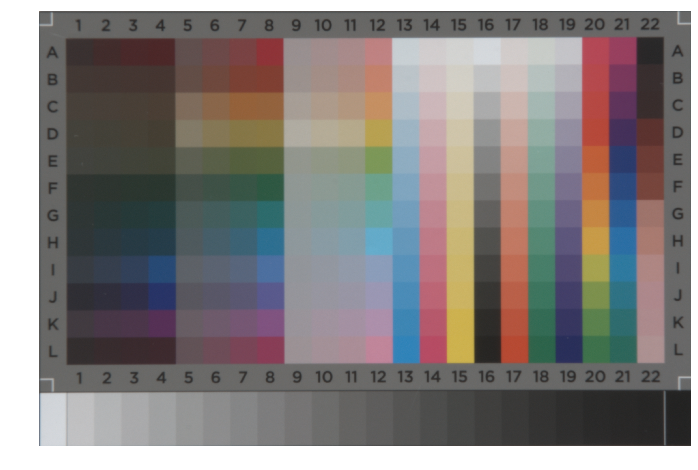

In [165]:
# Show IT8 chart
# Valid imshow range with RGB data: [0..1] for floats or [0..255] for integers
ZOOM = 4
plt.figure(figsize = (3 * ZOOM, 2 * ZOOM))
plt.imshow((img / 65535) ** (1 / 2.2))
plt.axis('off');

In [166]:
# Calculate median RGB values over each patch
width = WIDTH / 24
height = HEIGHT / 16
dX, dY = width / 7, height / 7  # safety margin

colours = np.zeros((22 * 12, 3))
grays = np.zeros((24, 3))
RGBvalues = np.zeros((22 * 12 + 24, 3))  # store RAW RGB_WB median values

# Colour patches
k = 0
for j in range(12):
    Y1, Y2 = round((j + 1) * height + dY), round((j + 2) * height - dY)
    for i in range(22):
        X1, X2 = round((i + 1) * width + dX), round((i + 2) * width - dX)
        for c in range(3):
            colours[k, c] = np.median(img[Y1:Y2, X1:X2, c])
            img[(Y1 - 2):(Y2 + 2), (X1 - 2):(X2 + 2), c] = 0
            img[Y1:Y2, X1:X2, c] = colours[k, c]
            RGBvalues[k, c] = colours[k, c]
        k = k + 1

# Gray patches
Y1, Y2 = round(14 * height + dY), round(16 * height - dY)
for i in range(24):
    X1, X2 = round((i + 0) * width + dX), round((i + 1) * width - dX)
    for c in range(3):
        grays[i, c] = np.median(img[Y1:Y2, X1:X2, c])
        img[(Y1 - 2):(Y2 + 2), (X1 - 2):(X2 + 2), c] = 0
        img[Y1:Y2, X1:X2, c] = grays[i, c]
        RGBvalues[k, c] = grays[i, c]
    k = k + 1
    
print("k =", k, "total patches") 

k = 288 total patches


In [167]:
# Features: X (RGB RAW + WB)
R1 = colours[:, 0].flatten()
G1 = colours[:, 1].flatten()
B1 = colours[:, 2].flatten()

R2 = grays[:, 0].flatten()
G2 = grays[:, 1].flatten()
B2 = grays[:, 2].flatten()

X = np.concatenate((np.column_stack((R1, G1, B1)),
                    np.column_stack((R2, G2, B2)))) / 65535  # WB-RAW RGB in 0..1 range

In [ ]:
# Write RAW RGB_WB median values 
np.savetxt("RGBvalues.csv", RGBvalues, delimiter=",")

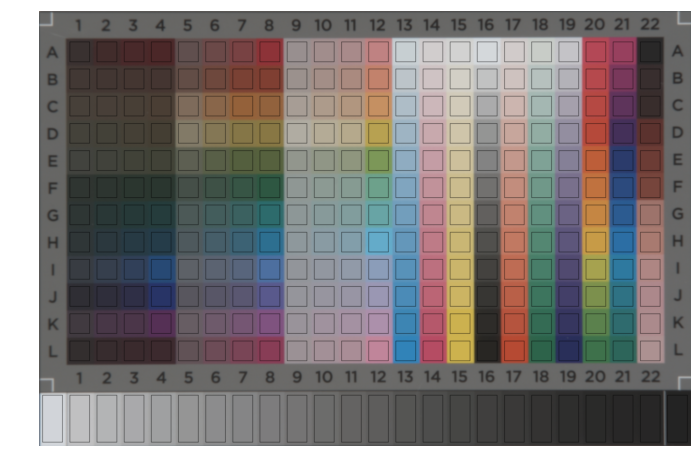

In [17]:
# Show used patches
# Valid imshow range with RGB data: [0..1] for floats or [0..255] for integers
ZOOM = 4
plt.figure(figsize = (3 * ZOOM, 2 * ZOOM))
plt.imshow((img / 65535) ** (1 / 2.2), interpolation='bilinear')
plt.axis('off');

In [18]:
# Save image
# io.imsave('IT8_crop_median.tif', img)
imageio.imwrite('IT8_crop_median.tif', img)

## Reading IT8 card XYZ/Lab theoretical output values

In [87]:
# 288 patches: 264 (0..263 = A1..L22) colour + 24 (264..287 = GS0..GS23) gray

In [173]:
# Target: Y
IT8 = pd.read_csv('IT8.txt', sep='\t', decimal='.')
IT8.head()

,Patch,X,Y,Z,L,a,b
0,1,3.27,2.81,1.96,19.2663,9.8319,3.3151
1,2,4.00,2.72,1.42,18.8857,22.7165,8.5147
2,3,4.99,2.80,1.36,19.2244,34.4973,9.8364
3,4,5.14,2.70,1.13,18.8000,38.1754,12.1526
4,5,12.09,10.63,7.33,38.9502,13.4014,5.5070


In [174]:
Y_XYZ = IT8[['X', 'Y', 'Z']].values / 100  # XYZ in the 0..1 range
Y_Lab = IT8[['L', 'a', 'b']].values        # Lab in the Lab range

## Training the neural network

In [14]:
# Define all NN's
NN = []
for layers in [(), (3, 3), (4, 4), (16, 16), (50, 50), (100, 100), (200, 200)]:
    for activation in ['tanh', 'logistic']:
        for out_activation in ['identity']:
            for target in ['XYZ', 'Lab']:
                NN.append([layers, activation, out_activation, target])
                print(NN[-1])

[(), 'tanh', 'identity', 'XYZ']
[(), 'tanh', 'identity', 'Lab']
[(), 'logistic', 'identity', 'XYZ']
[(), 'logistic', 'identity', 'Lab']
[(3, 3), 'tanh', 'identity', 'XYZ']
[(3, 3), 'tanh', 'identity', 'Lab']
[(3, 3), 'logistic', 'identity', 'XYZ']
[(3, 3), 'logistic', 'identity', 'Lab']
[(4, 4), 'tanh', 'identity', 'XYZ']
[(4, 4), 'tanh', 'identity', 'Lab']
[(4, 4), 'logistic', 'identity', 'XYZ']
[(4, 4), 'logistic', 'identity', 'Lab']
[(16, 16), 'tanh', 'identity', 'XYZ']
[(16, 16), 'tanh', 'identity', 'Lab']
[(16, 16), 'logistic', 'identity', 'XYZ']
[(16, 16), 'logistic', 'identity', 'Lab']
[(50, 50), 'tanh', 'identity', 'XYZ']
[(50, 50), 'tanh', 'identity', 'Lab']
[(50, 50), 'logistic', 'identity', 'XYZ']
[(50, 50), 'logistic', 'identity', 'Lab']
[(100, 100), 'tanh', 'identity', 'XYZ']
[(100, 100), 'tanh', 'identity', 'Lab']
[(100, 100), 'logistic', 'identity', 'XYZ']
[(100, 100), 'logistic', 'identity', 'Lab']
[(200, 200), 'tanh', 'identity', 'XYZ']
[(200, 200), 'tanh', 'identity',

In [ ]:
# Train all NN's
for i in range(len(NN)):
    nn = NN[i]
    regr = MLPRegressor(solver='adam', # solver algorithm ('sgd', 'lbfgs', 'adam')
                        alpha=0,        # no L2 (ridge regression) regularization
                        hidden_layer_sizes=nn[0],  # tuple defining layers and nodes
                        # early_stopping=True,
                        # validation_fraction=0.05,
                        activation=nn[1],      # hidden layers activation function (default 'relu') 
                                                # 'logistic' (sigmoid) works better than 'relu' and 'tanh'
                        max_iter=20800,  # max_iter=20800,         # max epochs
                        tol=0.000000000001,     # tolerance for early stopping
                        n_iter_no_change=10000,  # number of epochs to check tol
                        random_state=42,        # guarantee reproducible training
                        verbose=True)           # tell me a story
    regr.out_activation_ = nn[2]  # output layer activation function (default 'identity')
                                       # 'identity' is adequate for regression
    if nn[3] == 'XYZ':
        regr.fit(X, Y_XYZ)
    else:
        regr.fit(X, Y_Lab)        
    
    # Save MLP
    nn_name = 'MLP_' + nn[3] + '_' + str(nn[0]) + '_' + nn[1] + '_' + nn[2]
    with open(nn_name + '.pkl', 'wb') as f:
        pickle.dump(regr, f)

In [165]:
# MLP weights -> WB-RAW RGB to XYZ 3x3 matrix conversion
regr.coefs_

[array([[ 0.79443793,  0.35856019,  0.06022069],
        [ 0.2781231 ,  0.99655999, -0.26346605],
        [ 0.12676705, -0.11509048,  1.21852841]])]

In [13]:
# MLP biases -> nearly 0's
regr.intercepts_

[array([-0.01059187, -0.00989786, -0.00368542])]

### Plot and save Loss vs Epochs

In [ ]:
# Load MLP (once trained and saved)
for i in range(len(NN)):
    nn = NN[i]
    nn_name = 'MLP_' + nn[3] + '_' + str(nn[0]) + '_' + nn[1] + '_' + nn[2]
    with open(nn_name + '.pkl', 'rb') as f:
        regr = pickle.load(f)

    # Plot error vs epoch
    plt.clf()
    plt.plot(regr.loss_curve_)
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.savefig(nn_name + '_LOSS.png')

## Conversion functions

### XYZ (D50) to Lab conversion

In [20]:
def XYZ_to_Lab(XYZ):  # XYZ is a Nx3 array in the 0..1 range
    """XYZ (D50) to Lab conversion
    Formulae from www.brucelindbloom.com
    """
    
    Xr = 0.96422  # D50/2° 1931 reference white
    Yr = 1.0
    Zr = 0.82521
    
    e = 0.008856
    k = 903.3

    xr = XYZ[:, 0] / Xr
    yr = XYZ[:, 1] / Yr
    zr = XYZ[:, 2] / Zr
    
    # Most usual cases (xr > e, yr > e, zr > e)
    fx = xr ** (1 / 3)
    fy = yr ** (1 / 3)
    fz = zr ** (1 / 3)
    
    # Least usual cases
    indx = tuple([xr <= e])  # not using tuple() works but is deprecated
    indy = tuple([yr <= e])
    indz = tuple([zr <= e])
        
    fx[indx] = (k * xr[indx] + 16) / 116
    fy[indy] = (k * yr[indy] + 16) / 116
    fz[indz] = (k * zr[indz] + 16) / 116
        
    L = 116 * fy - 16
    a = 500 * (fx - fy)
    b = 200 * (fy - fz)
        
    return np.column_stack((L, a, b))  # output is a Nx3 array in the Lab range

In [19]:
# Test 1
XYZ_to_Lab(np.array([[0.5, 0.7, 0.2]]))

array([[ 86.9968642 , -42.25249828,  52.88499815]])

In [20]:
# Test 2
np.max(Y_Lab - XYZ_to_Lab(Y_XYZ))

0.004250301821224767

### Lab to XYZ (D50) conversion

In [21]:
def Lab_to_XYZ(Lab):  # Lab is a Nx3 array in the Lab range
    """Lab to XYZ (D50) conversion
    Formulae from www.brucelindbloom.com
    """
    
    Xr = 0.96422  # D50/2° 1931 reference white
    Yr = 1.0
    Zr = 0.82521
    
    e = 0.008856
    k = 903.3
    
    L = Lab[:, 0]
    a = Lab[:, 1]
    b = Lab[:, 2]
    
    fy = (L + 16) / 116
    fx = a / 500 + fy
    fz = fy - b / 200
    
    # Most usual cases (fx^3 > e, L > ke, fz^3 > e)
    xr = fx ** 3
    yr = ((L + 16) / 116)  ** 3
    zr = fz ** 3
    
    # Least usual cases
    indx = tuple([fx ** 3 <= e])  # not using tuple() works but is deprecated
    indy = tuple([L <= k * e])
    indz = tuple([fz ** 3 <= e])
    
    xr[indx] = (116 * fx[indx] - 16) / k
    yr[indy] = L[indy] / k
    zr[indz] = (116 * fz[indz] - 16) / k
    
    X = xr * Xr
    Y = yr * Yr
    Z = zr * Zr
    
    return np.column_stack((X, Y, Z))  # output is a Nx3 array in the 0..1 range

In [3]:
# Test 1
Lab_to_XYZ(np.array([[86.9968642, -42.25249828, 52.88499815]]))

array([[0.5, 0.7, 0.2]])

In [23]:
# Test 2: return ticket
XYZ = Lab_to_XYZ(Y_Lab)
Y_Lab_bis = XYZ_to_Lab(XYZ)
np.max(Y_Lab_bis - Y_Lab)

6.161737786669619e-14

In [24]:
# Test 3
np.max(Lab_to_XYZ(Y_Lab) - Y_XYZ)

9.907123973418308e-07

In [25]:
# Test 4: return ticket
Lab = XYZ_to_Lab(Y_XYZ)
Y_XYZ_bis = Lab_to_XYZ(Lab)
np.max(Y_XYZ_bis - Y_XYZ)

3.3306690738754696e-16

### XYZ (D50) to sRGB (D65) conversion

In [155]:
def XYZ_to_sRGB(XYZ):  # XYZ is a Nx3 array in the 0..1 range
    """XYZ (D50) to sRGB (D65) conversion using D50 to D65 Bradford adaption
    Formulae from www.brucelindbloom.com
    """
    
    X = XYZ[:, 0]
    Y = XYZ[:, 1]
    Z = XYZ[:, 2]
    
    r = 3.1338561 * X - 1.6168667 * Y - 0.4906146 * Z
    g =-0.9787684 * X + 1.9161415 * Y + 0.0334540 * Z
    b = 0.0719453 * X - 0.2289914 * Y + 1.4052427 * Z
    
    # Clip to 0..1 range
    r[r < 0] = 0.0
    r[r > 1] = 1.0
    g[g < 0] = 0.0
    g[g > 1] = 1.0
    b[b < 0] = 0.0
    b[b > 1] = 1.0
    
    # Most usual cases (r, g, b > 0.0031308)
    R = 1.055 * r**(1 / 2.4) - 0.055
    G = 1.055 * g**(1 / 2.4) - 0.055
    B = 1.055 * b**(1 / 2.4) - 0.055
    
    # Least usual cases
    indr = tuple([r <= 0.0031308])  # not using tuple() works but is deprecated
    indg = tuple([g <= 0.0031308])
    indb = tuple([b <= 0.0031308])
    
    R[indr] = 12.92 * r[indr]
    G[indg] = 12.92 * g[indg]
    B[indb] = 12.92 * b[indb]
    
    return np.column_stack((R, G, B))  # output is a Nx3 array in the 0..1 range

In [156]:
# Test 1
XYZ_to_sRGB(np.array([[0.5, 0.7, 0.2]])) * 255

array([[156.96508483, 238.44320903, 110.26498658]])

In [159]:
# Test 2
XYZ_to_sRGB(np.array([[0, 0, 0.001]])) * 255

array([[0.        , 0.11021755, 4.6297126 ]])

### XYZ (D50) to ProPhoto RGB (D50) conversion

In [23]:
def XYZ_to_ProPhotoRGB(XYZ):  # XYZ is a Nx3 array in the 0..1 range
    """XYZ (D50) to ProPhoto RGB (D50) conversion (no adaption needed)
    Formulae from www.brucelindbloom.com
    """
    
    X = XYZ[:, 0]
    Y = XYZ[:, 1]
    Z = XYZ[:, 2]
    
    r = 1.3459433 * X - 0.2556075 * Y - 0.0511118 * Z
    g =-0.5445989 * X + 1.5081673 * Y + 0.0205351 * Z
    b = 0.0000000 * X + 0.0000000 * Y + 1.2118128 * Z
    
    # Clip to 0..1 range
    r[r < 0] = 0.0
    r[r > 1] = 1.0
    g[g < 0] = 0.0
    g[g > 1] = 1.0
    b[b < 0] = 0.0
    b[b > 1] = 1.0
    
    return np.column_stack((r, g, b)) ** (1 / 1.8)  # output is a Nx3 array in the 0..1 range

In [29]:
# Test 1
XYZ_to_ProPhotoRGB(np.array([[0.5, 0.7, 0.2]])) * 255

array([[170.35957108, 223.31051101, 116.03168168]])

### Delta E (CIE76) calculation

In [24]:
def DeltaE(Lab1, Lab2):  # Lab1 and Lab2 are Nx3 arrays in the Lab range
    """Delta E (CIE76) calculation
       ΔE ~ 2.3 corresponds to a just noticeable difference
       ΔE Quality:
         <1 = Excellent (imperceptible)
        1-2 = Good
        2-4 = Normal
        4-5 = Sufficient
         >5 = Bad
    """
    
    return np.sqrt((Lab1[:, 0] - Lab2[:, 0]) ** 2 +
                   (Lab1[:, 1] - Lab2[:, 1]) ** 2 +
                   (Lab1[:, 2] - Lab2[:, 2]) ** 2)  # ouput is a Nx1 array in the Lab range

## Neural network prediction

### Plot correlations

In [ ]:
# Load MLP (once trained and saved)
for i in range(len(NN)):
    nn = NN[i]
    nn_name = 'MLP_' + nn[3] + '_' + str(nn[0]) + '_' + nn[1] + '_' + nn[2]
    with open(nn_name + '.pkl', 'rb') as f:
        regr = pickle.load(f)

    # Prediction
    Y_pred = regr.predict(X)
    
    # Clip to 0..1 range
    # Y_pred[Y_pred < 0] = 0.0
    # Y_pred[Y_pred > 1] = 1.0

    if nn[3] == 'XYZ':
        Y = Y_XYZ
        label1, label2, label3 = 'X', 'Y', 'Z'
    else:
        Y = Y_Lab
        label1, label2, label3 = 'L', 'a', 'b'
        
    # Plot predicted vs real
    plt.clf()
    plt.subplots(figsize=(13, 4))

    plt.subplot(131)
    plt.scatter(Y[:, 0], Y_pred[:, 0], alpha=0.2)
    plt.xlabel('Real ' + label1)
    plt.ylabel('Predicted ' + label1)

    plt.subplot(132)
    plt.scatter(Y[:, 1], Y_pred[:, 1], alpha=0.2)
    plt.xlabel('Real ' + label2)
    plt.ylabel('Predicted ' + label2)

    plt.subplot(133)
    plt.scatter(Y[:, 2], Y_pred[:, 2], alpha=0.2)
    plt.xlabel('Real ' + label3)
    plt.ylabel('Predicted ' + label3)
    
    plt.savefig(nn_name + '_CORR.png')

### Print and Plot Delta E stats and distribution

In [ ]:
# Load MLP (once trained and saved)
for i in range(len(NN)):
    nn = NN[i]
    nn_name = 'MLP_' + nn[3] + '_' + str(nn[0]) + '_' + nn[1] + '_' + nn[2]
    with open(nn_name + '.pkl', 'rb') as f:
        regr = pickle.load(f)

    # Prediction
    Y_pred = regr.predict(X)
    
    # Clip to 0..1 range
    # Y_pred[Y_pred < 0] = 0.0
    # Y_pred[Y_pred > 1] = 1.0

    if nn[3] == 'XYZ':
        Y_pred = XYZ_to_Lab(Y_pred)  # convert to Lab all XYZ models
    
    DeltaE_ = DeltaE(Y_Lab, Y_pred)

    print(nn_name,
          ": ΔE_max = %.4f" % np.max(DeltaE_),
          ", ΔE_mean = %.4f" % np.mean(DeltaE_),
          ", ΔE_median = %.4f" % np.median(DeltaE_))
    
    # Plot Delta E distribution
    plt.rcParams.update({'figure.max_open_warning': 0})  # get rid of warnings
    plt.clf()
    plt.subplots(figsize=(13, 5))
    plt.hist(DeltaE_, bins=150, range=[0, 8], color='b', alpha=0.5)
    plt.savefig(nn_name + '_HIST.png')  

## MLP validation

In [160]:
# Best trade-off complexity vs performance model
with open('MLP_Lab_(50, 50)_tanh_identity.pkl', 'rb') as f:
    regr = pickle.load(f)

### Interpolate values

In [168]:
X_gray = X[264:287+1, :]  # RGB_WB values on gray patches
X_gray.shape

(24, 3)

In [169]:
TRAMOS = len(X_gray) - 1
NUM_INTERP = 20  # values to interpolate

X_gray_interp = np.zeros([len(X_gray) + TRAMOS * NUM_INTERP, 3])

for n in range(TRAMOS):
    START = X_gray[n, :]
    STOP = X_gray[n + 1, :]
    for c in range(3):
        interp = np.linspace(START[c], STOP[c], NUM_INTERP + 2)
        X_gray_interp[n * (NUM_INTERP + 1):(n + 1) * (NUM_INTERP + 1) + 1, c] = interp

In [171]:
Y_pred_gray = regr.predict(X_gray)
Y_pred_gray_interp = regr.predict(X_gray_interp)

<Figure size 432x288 with 0 Axes>

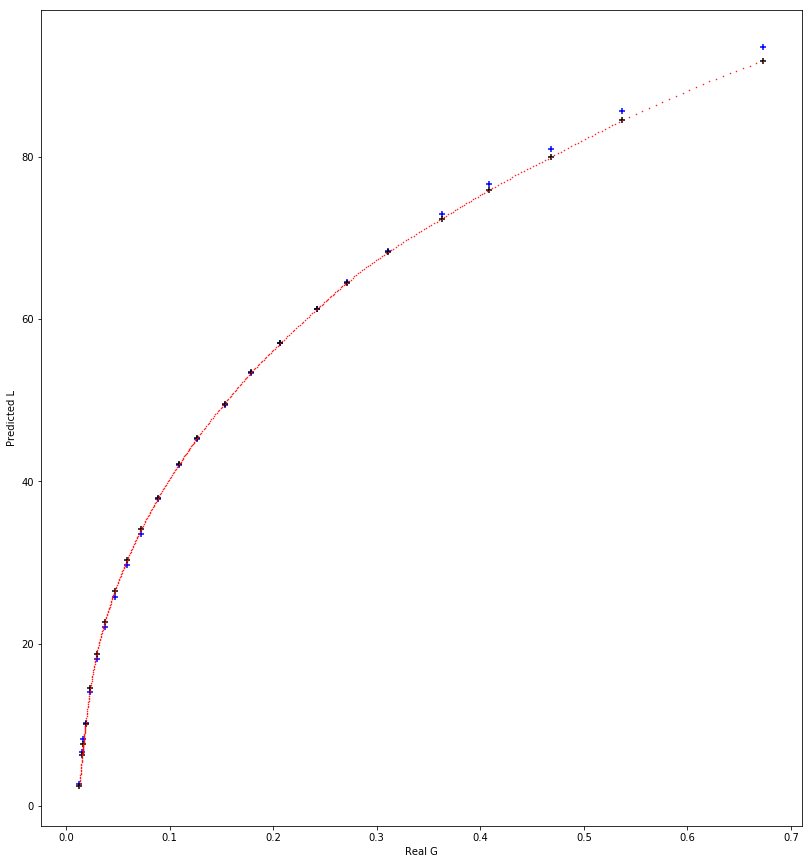

In [175]:
# Plot predicted vs real
plt.clf()
plt.subplots(figsize=(30, 15));

plt.subplot(121)
plt.scatter(X_gray[:, 1], Y_Lab[264:287+1, 0], marker='+', color='blue')
plt.scatter(X_gray[:, 1], Y_pred_gray[:, 0], marker='+', color='black')
plt.scatter(X_gray_interp[:, 1], Y_pred_gray_interp[:, 0], marker='.', color='red', s=1)
plt.xlabel('Real G')
plt.ylabel('Predicted L');

### Prediction vs exact values

In [33]:
img = imageio.imread('IT8.tiff')  # RGB RAW + WB

# Crop IT8 (6016 x 4016 pixels -> 3609 x 2408 pixels)
X1, X2 = 1201, 4810
Y1, Y2 = 832, 3240

img = img[Y1:Y2, X1:X2]

In [ ]:
HEIGHT = img.shape[0]
WIDTH = img.shape[1]

In [221]:
# Flatten
R = img[:, :, 0].flatten()
G = img[:, :, 1].flatten()
B = img[:, :, 2].flatten()

X_train = np.column_stack((R, G, B)) / 65535

In [222]:
del img, R, G, B  # save memory

In [223]:
# Prediction
Y_pred = regr.predict(X_train)  # Lab values

In [37]:
# Reshape as (Lab) image
L_pred = Y_pred[:, 0].reshape(HEIGHT, WIDTH)
a_pred = Y_pred[:, 1].reshape(HEIGHT, WIDTH)
b_pred = Y_pred[:, 2].reshape(HEIGHT, WIDTH)

img = np.zeros((HEIGHT, WIDTH, 3), dtype=np.float64)
img[:, :, 0] = L_pred
img[:, :, 1] = a_pred
img[:, :, 2] = b_pred

In [38]:
# Write Y_Lab values (expected target values) on the right half of every patch
width = WIDTH / 24
height = HEIGHT / 16
dX, dY = width / 7, height / 7  # safety margin

# Colour patches
k = 0
for j in range(12):
    Y1, Y2 = round((j + 1) * height + dY), round((j + 2) * height - dY)
    for i in range(22):
        X1, X2 = round((i + 1) * width + width / 2), round((i + 2) * width - dX)
        for c in range(3):
            img[Y1:Y2, X1:X2, c] = Y_Lab[k, c]
        k = k + 1

# Gray patches
Y1, Y2 = round(14 * height + dY), round(16 * height - dY)
for i in range(24):
    X1, X2 = round((i + 0) * width + width / 2), round((i + 1) * width - dX)
    for c in range(3):
        img[Y1:Y2, X1:X2, c] = Y_Lab[k, c]
    k = k + 1
    
print("k =", k, "total patches")        

k = 288 total patches


In [39]:
# Flatten
L = img[:, :, 0].flatten()
a = img[:, :, 1].flatten()
b = img[:, :, 2].flatten()

Y_pred = np.column_stack((L, a, b))

In [40]:
Y_pred_ProPhotoRGB = XYZ_to_ProPhotoRGB(Lab_to_XYZ(Y_pred))  # Lab -> XYZ -> ProPhoto RGB conversion

In [41]:
# Build prediction image
R_pred = Y_pred_ProPhotoRGB[:, 0].reshape(HEIGHT, WIDTH)
G_pred = Y_pred_ProPhotoRGB[:, 1].reshape(HEIGHT, WIDTH)
B_pred = Y_pred_ProPhotoRGB[:, 2].reshape(HEIGHT, WIDTH)

prediction = np.zeros((HEIGHT, WIDTH, 3), dtype=np.float64)
prediction[:, :, 0] = R_pred
prediction[:, :, 1] = G_pred
prediction[:, :, 2] = B_pred

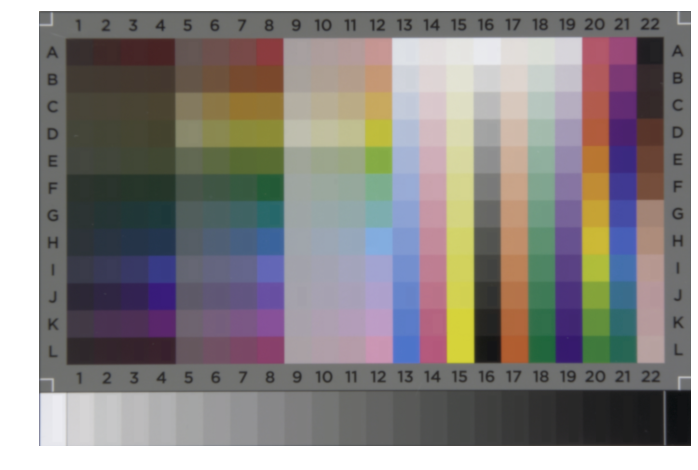

In [42]:
# Show image
# Valid imshow range with RGB data: [0..1] for floats or [0..255] for integers
ZOOM = 4
plt.figure(figsize = (3 * ZOOM, 2 * ZOOM))
plt.imshow(prediction ** (1.8 / 2.2), interpolation='bilinear')  # undo ProPhoto RGB gamma
plt.axis('off');

In [43]:
# Save image
# io.imsave('IT8_pred_ProPhotoRGB_comp.tif', prediction)
prediction = np.round(prediction * 65535).astype('uint16')  # range [0..65535]
imageio.imwrite('IT8_pred_ProPhotoRGB_comp.tif', prediction)

### Test image 'bodegon'

In [138]:
# dcraw -v -w -o 0 -4 -T bodegon.NEF
img = imageio.imread('bodegon.tiff') * 4  # increase RAW values by 4EV (RAW file was very underexposed)

In [139]:
img.shape

(4016, 6016, 3)

In [140]:
HEIGHT = img.shape[0]
WIDTH = img.shape[1]

In [141]:
# Flatten
R = img[:, :, 0].flatten()
G = img[:, :, 1].flatten()
B = img[:, :, 2].flatten()

X_test = np.column_stack((R, G, B)) / 65535

In [142]:
del img, R, G, B  # save memory

In [143]:
# Prediction
Y_pred = regr.predict(X_test)  # Lab values

In [144]:
# Clip L values
Y_pred[:, 0][Y_pred[:, 0] < 0] = 0.0
Y_pred[:, 0][Y_pred[:, 0] > 100] = 100.0

In [145]:
Y_pred_XYZ = Lab_to_XYZ(Y_pred)  # Lab -> XYZ conversion

In [146]:
# Clip XYZ values
Y_pred_XYZ[Y_pred_XYZ < 0] = 0.0
Y_pred_XYZ[Y_pred_XYZ > 1] = 1.0

In [147]:
Y_pred_ProPhotoRGB = XYZ_to_ProPhotoRGB(Y_pred_XYZ)  # XYZ -> ProPhoto RGB conversion

In [148]:
# Build prediction image
R_pred = Y_pred_ProPhotoRGB[:, 0].reshape(HEIGHT, WIDTH)
G_pred = Y_pred_ProPhotoRGB[:, 1].reshape(HEIGHT, WIDTH)
B_pred = Y_pred_ProPhotoRGB[:, 2].reshape(HEIGHT, WIDTH)

prediction = np.zeros((HEIGHT, WIDTH, 3), dtype=np.float64)
prediction[:, :, 0] = R_pred
prediction[:, :, 1] = G_pred
prediction[:, :, 2] = B_pred

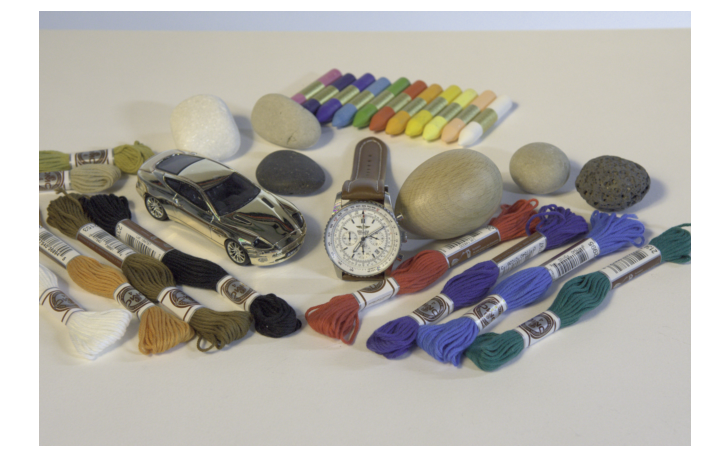

In [149]:
# Show image
# Valid imshow range with RGB data: [0..1] for floats or [0..255] for integers
ZOOM = 4
plt.figure(figsize = (3 * ZOOM, 2 * ZOOM))
plt.imshow(prediction ** (1.8 / 2.2), interpolation='bilinear')  # undo ProPhoto RGB gamma
plt.axis('off');

In [150]:
# Save image
# io.imsave('IT8_pred_ProPhotoRGB_comp.tif', prediction)
prediction = np.round(prediction * 65535).astype('uint16')  # range [0..65535]
imageio.imwrite('bodegon_pred_ProPhotoRGB_CLIPPED.tif', prediction)

### Test all input colours

In [35]:
img = imageio.imread('RGB16Million.tif')  # all 8-bit colours in 16-bit encoding

In [36]:
HEIGHT = img.shape[0]
WIDTH = img.shape[1]

In [37]:
# Flatten
R = img[:, :, 0].flatten()
G = img[:, :, 1].flatten()
B = img[:, :, 2].flatten()

X_test = np.column_stack((R, G, B)) / 65535

In [47]:
del img, R, G, B  # save memory

In [50]:
# Prediction -> takes ~14s
Y_pred = regr.predict(X_test)  # Lab values

In [54]:
# Check Lab limits reached
print("L values range from", np.min(Y_pred[:, 0]), "to", np.max(Y_pred[:, 0]))
print("a values range from", np.min(Y_pred[:, 1]), "to", np.max(Y_pred[:, 1]))
print("b values range from", np.min(Y_pred[:, 2]), "to", np.max(Y_pred[:, 2]))

L values range from -11.473477324249627 to 99.29478524040503
a values range from -99.26699286778262 to 95.06266638162435
b values range from -81.82802735864902 to 113.86684853244434


In [57]:
# Clip L values
Y_pred[:, 0][Y_pred[:, 0] < 0] = 0.0
Y_pred[:, 0][Y_pred[:, 0] > 100] = 100.0

In [58]:
# Check Lab limits reached
print("L values range from", np.min(Y_pred[:, 0]), "to", np.max(Y_pred[:, 0]))
print("a values range from", np.min(Y_pred[:, 1]), "to", np.max(Y_pred[:, 1]))
print("b values range from", np.min(Y_pred[:, 2]), "to", np.max(Y_pred[:, 2]))

L values range from 0.0 to 99.29478524040503
a values range from -99.26699286778262 to 95.06266638162435
b values range from -81.82802735864902 to 113.86684853244434


In [59]:
Y_pred_XYZ = Lab_to_XYZ(Y_pred)  # Lab -> XYZ conversion

In [61]:
# Clip XYZ values
Y_pred_XYZ[Y_pred_XYZ < 0] = 0.0
Y_pred_XYZ[Y_pred_XYZ > 1] = 1.0

In [62]:
# Check XYZ limits reached (with XYZ clipping)
print("X values range from", np.min(Y_pred_XYZ[:, 0]), "to", np.max(Y_pred_XYZ[:, 0]))
print("Y values range from", np.min(Y_pred_XYZ[:, 1]), "to", np.max(Y_pred_XYZ[:, 1]))
print("Z values range from", np.min(Y_pred_XYZ[:, 2]), "to", np.max(Y_pred_XYZ[:, 2]))

X values range from 0.0 to 0.9433762086952517
Y values range from 0.0 to 0.9818723412424746
Z values range from 0.0 to 0.8061221705396618


In [63]:
Y_pred_ProPhotoRGB = XYZ_to_ProPhotoRGB(Y_pred_XYZ)  # XYZ -> ProPhoto RGB conversion

In [64]:
# Check RGB limits reached
print("R values range from", np.min(Y_pred_ProPhotoRGB[:, 0]), "to", np.max(Y_pred_ProPhotoRGB[:, 0]))
print("G values range from", np.min(Y_pred_ProPhotoRGB[:, 1]), "to", np.max(Y_pred_ProPhotoRGB[:, 1]))
print("B values range from", np.min(Y_pred_ProPhotoRGB[:, 2]), "to", np.max(Y_pred_ProPhotoRGB[:, 2]))

R values range from 0.0 to 0.9968818185288296
G values range from 0.0 to 0.9940811007464738
B values range from 0.0 to 0.9870827359183564


In [65]:
# Build prediction image
R_pred = Y_pred_ProPhotoRGB[:, 0].reshape(HEIGHT, WIDTH)
G_pred = Y_pred_ProPhotoRGB[:, 1].reshape(HEIGHT, WIDTH)
B_pred = Y_pred_ProPhotoRGB[:, 2].reshape(HEIGHT, WIDTH)

prediction = np.zeros((HEIGHT, WIDTH, 3), dtype=np.float64)
prediction[:, :, 0] = R_pred
prediction[:, :, 1] = G_pred
prediction[:, :, 2] = B_pred

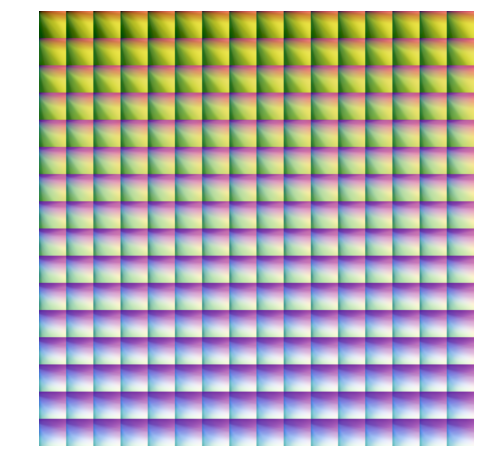

In [33]:
# Show image
# Valid imshow range with RGB data: [0..1] for floats or [0..255] for integers
ZOOM = 4
plt.figure(figsize = (3 * ZOOM, 2 * ZOOM))
plt.imshow(prediction ** (1.8 / 2.2), interpolation='bilinear')  # undo ProPhoto RGB gamma
plt.axis('off');

In [67]:
# Save image
# io.imsave('IT8_pred_ProPhotoRGB_comp.tif', prediction)
prediction = np.round(prediction * 65535).astype('uint16')  # range [0..65535]
imageio.imwrite('RGB16Million_pred_CLIPPED.tif', prediction)